In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["JAX_ENABLE_X64"] = "True"

In [2]:
from functools import partial

import jax.numpy as jnp
import typer
from jax import jit, random, vmap
from jax._src.prng import PRNGKeyArray

from bpd import DATA_DIR
from bpd.draw import draw_gaussian
from bpd.initialization import init_with_truth
from bpd.io import save_dataset
from bpd.likelihood import gaussian_image_loglikelihood
from bpd.pipelines import pipeline_interim_samples_one_galaxy
from bpd.prior import interim_gprops_logprior
from bpd.sample import (
    get_target_images,
    get_true_params_from_galaxy_params,
    sample_target_galaxy_params_simple,
)

from functools import partial
import jax
import jax.numpy as jnp
import typer
from jax import jit

from bpd import DATA_DIR
from bpd.io import load_dataset
from bpd.pipelines import pipeline_shear_inference_simple


import matplotlib.pyplot as plt 


In [3]:
def sample_prior(
    rng_key: PRNGKeyArray,
    *,
    mean_logflux: float,
    sigma_logflux: float,
    shape_noise: float,
    g1: float = 0.02,
    g2: float = 0.0,
) -> dict[str, float]:
    k1, k2 = random.split(rng_key)

    lf = random.normal(k1) * sigma_logflux + mean_logflux
    other_params = sample_target_galaxy_params_simple(
        k2, shape_noise=shape_noise, g1=g1, g2=g2
    )

    return {"lf": lf, "hlr": 0.8, **other_params}

In [4]:
seed = 42
rng_key = jax.random.key(seed)

In [5]:
n_gals: int = 100
n_samples_per_gal: int = 300
mean_logflux: float = 2.6
sigma_logflux: float = 0.4
g1: float = 0.02
g2: float = 0.0
shape_noise: float = 0.1
sigma_e_int: float = 0.15
slen: int = 63
fft_size: int = 256
background: float = 1.0
initial_step_size: float = 1e-3

## Check convergence and efficiency of high noise galaxy chains

In [ ]:
keys = random.split(rng_key, 3)

# galaxy parameters from prior
pkeys = random.split(keys[0], n_gals)
_get_galaxy_params = partial(
    sample_prior,
    shape_noise=shape_noise,
    mean_logflux=mean_logflux,
    sigma_logflux=sigma_logflux,
    g1=g1,
    g2=g2,
)
galaxy_params = vmap(_get_galaxy_params)(pkeys)
assert galaxy_params["x"].shape == (n_gals,)
assert galaxy_params["e1"].shape == (n_gals,)

# now get corresponding target images
draw_params = {**galaxy_params}
draw_params["f"] = 10 ** draw_params.pop("lf")
target_images = get_target_images(
    keys[1], draw_params, background=background, slen=slen
)
assert target_images.shape == (n_gals, slen, slen)

# interim samples are on 'sheared ellipticity'
true_params = vmap(get_true_params_from_galaxy_params)(galaxy_params)
fixed_params = {
    "x": true_params.pop("x"),
    "y": true_params.pop("y"),
    "f": 10 ** true_params.pop("lf"),
    "hlr": true_params.pop("hlr"),
}

# setup prior and likelihood
_logprior = partial(
    interim_gprops_logprior,
    sigma_e=sigma_e_int,
    free_flux_hlr=False,
    free_dxdy=False,
)
_draw_fnc = partial(draw_gaussian, slen=slen, fft_size=fft_size)
_loglikelihood = partial(
    gaussian_image_loglikelihood,
    draw_fnc=_draw_fnc,
    background=background,
    free_flux_hlr=False,
    free_dxdy=False,
)

# prepare pipelines
gkeys = random.split(keys[2], (4, n_gals))
pipe = partial(
    pipeline_interim_samples_one_galaxy,
    initialization_fnc=init_with_truth,
    logprior=_logprior,
    loglikelihood=_loglikelihood,
    n_samples=n_samples_per_gal,
    initial_step_size=initial_step_size,
)
vpipe = vmap(vmap(jit(pipe)), in_axes=(0, None, None, None))

samples = vpipe(gkeys, true_params, target_images, fixed_params)

In [49]:
samples['e1'].shape

(4, 100, 300)

In [50]:
# check convergence
from blackjax.diagnostics import effective_sample_size, potential_scale_reduction
ess_s = []
rhats = []

for ii in range(n_gals):
    ess_s.append(effective_sample_size(samples['e1'][:, ii, :], chain_axis=0, sample_axis=1))
    rhats.append(potential_scale_reduction(samples['e1'][:, ii, :], chain_axis=0, sample_axis=1))

ess = jnp.array(ess_s)
rhats = jnp.array(rhats)

In [51]:
ess.shape, rhats.shape

((100,), (100,))

(array([ 1.,  2., 10., 11., 21., 25., 20.,  6.,  2.,  2.]),
 array([0.47095735, 0.54096518, 0.61097301, 0.68098084, 0.75098867,
        0.8209965 , 0.89100434, 0.96101217, 1.03102   , 1.10102783,
        1.17103566]),
 <BarContainer object of 10 artists>)

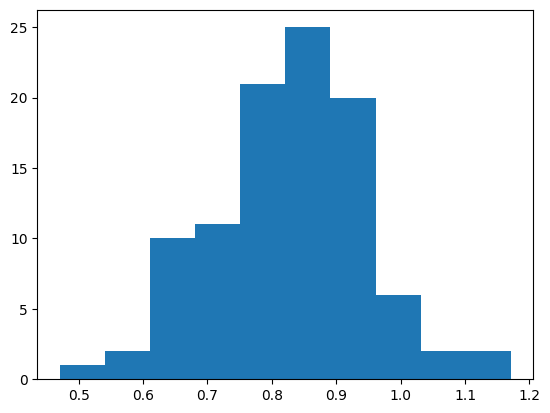

In [53]:
plt.hist(ess / (4*300))

(array([32., 25., 18., 10.,  5.,  3.,  4.,  1.,  0.,  2.]),
 array([0.99857129, 0.99941793, 1.00026456, 1.0011112 , 1.00195783,
        1.00280447, 1.0036511 , 1.00449774, 1.00534437, 1.00619101,
        1.00703765]),
 <BarContainer object of 10 artists>)

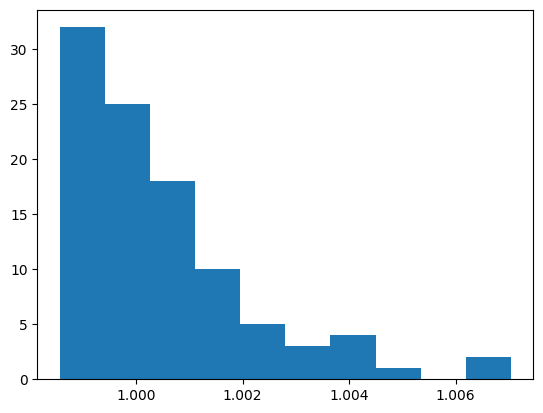

In [55]:
plt.hist(rhats)

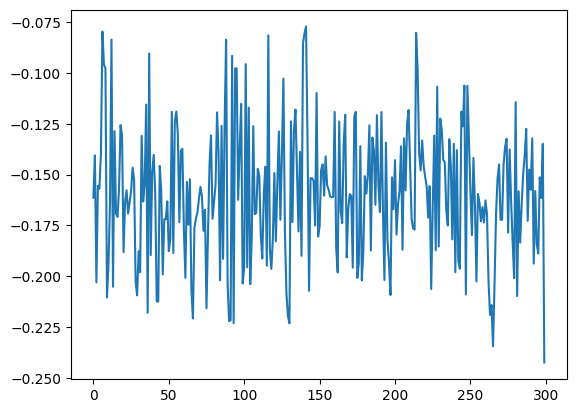

In [63]:
for ii in range(1):
    plt.plot(samples['e1'][ii, 99, :])

## Try to get symmetric posterior with low number of galaxies and high noise

In [6]:
# from bpd.io import load_dataset
# load_dataset("/pscratch/sd/i/imendoza/data/cache_chains/exp41_43/interim_samples_43_minus.npz")['e_post'].shape

In [30]:
def get_galaxy_samples(rng_key, g1=0.02, g2=0.0, n_gals=100, mean_logflux=2.6, sigma_logflux=0.4, shape_noise=0.1, sigma_e_int=0.15, slen=63, 
                       fft_size=256, background=1.0, initial_step_size=1e-3 ):


    keys = random.split(rng_key, 3)

    
    # galaxy parameters from prior
    pkeys = random.split(keys[0], n_gals)
    _get_galaxy_params = partial(
        sample_prior,
        shape_noise=shape_noise,
        mean_logflux=mean_logflux,
        sigma_logflux=sigma_logflux,
        g1=g1,
        g2=g2,
    )
    galaxy_params = vmap(_get_galaxy_params)(pkeys)
    assert galaxy_params["x"].shape == (n_gals,)
    assert galaxy_params["e1"].shape == (n_gals,)
    
    # now get corresponding target images
    draw_params = {**galaxy_params}
    draw_params["f"] = 10 ** draw_params.pop("lf")
    target_images = get_target_images(
        keys[1], draw_params, background=background, slen=slen
    )
    assert target_images.shape == (n_gals, slen, slen)
    
    # interim samples are on 'sheared ellipticity'
    true_params = vmap(get_true_params_from_galaxy_params)(galaxy_params)
    fixed_params = {
        "x": true_params.pop("x"),
        "y": true_params.pop("y"),
        "f": 10 ** true_params.pop("lf"),
        "hlr": true_params.pop("hlr"),
    }
    
    # setup prior and likelihood
    _logprior = partial(
        interim_gprops_logprior,
        sigma_e=sigma_e_int,
        free_flux_hlr=False,
        free_dxdy=False,
    )
    _draw_fnc = partial(draw_gaussian, slen=slen, fft_size=fft_size)
    _loglikelihood = partial(
        gaussian_image_loglikelihood,
        draw_fnc=_draw_fnc,
        background=background,
        free_flux_hlr=False,
        free_dxdy=False,
    )
    
    # prepare pipelines
    gkeys = random.split(keys[2], n_gals)
    pipe = partial(
        pipeline_interim_samples_one_galaxy,
        initialization_fnc=init_with_truth,
        logprior=_logprior,
        loglikelihood=_loglikelihood,
        n_samples=n_samples_per_gal,
        initial_step_size=initial_step_size,
    )
    vpipe = vmap(jit(pipe))

    _ = vpipe(gkeys[:2], {k:v[:2] for k,v in true_params.items()}, target_images[:2], {k:v[:2] for k,v in fixed_params.items()})
    
    return vpipe(gkeys, true_params, target_images, fixed_params)

In [31]:
seed = 51
rng_key = random.key(seed)

k1, k2 = random.split(rng_key)

In [32]:
_shape_noise = 0.001
_sigma_e_int = 0.05

In [33]:
samples_plus = get_galaxy_samples(k1, g1=0.02, n_gals=100, mean_logflux=6.0, sigma_logflux=0.1, 
                                  shape_noise=_shape_noise, sigma_e_int=_sigma_e_int)

In [34]:
samples_minus = get_galaxy_samples(k1, g1=-0.02, n_gals=100, mean_logflux=6.0, sigma_logflux=0.1, 
                                  shape_noise=_shape_noise, sigma_e_int=_sigma_e_int)

In [35]:
e_post_plus = jnp.stack([samples_plus['e1'], samples_plus['e2']], axis=-1)
e_post_minus = jnp.stack([samples_minus['e1'], samples_minus['e2']], axis=-1)

e_post_plus.shape, e_post_minus.shape

((100, 300, 2), (100, 300, 2))

(array([ 300.,    0.,    0.,   61.,  540.,  301.,  673.,  981., 1634.,
        2050., 3048., 3004., 2835., 1820., 3708., 1831., 1856., 1609.,
        1273.,  976.,  900.,  300.,    0.,    0.,  300.]),
 array([0.01651508, 0.01676969, 0.01702429, 0.01727889, 0.0175335 ,
        0.0177881 , 0.01804271, 0.01829731, 0.01855191, 0.01880652,
        0.01906112, 0.01931573, 0.01957033, 0.01982493, 0.02007954,
        0.02033414, 0.02058875, 0.02084335, 0.02109795, 0.02135256,
        0.02160716, 0.02186177, 0.02211637, 0.02237097, 0.02262558,
        0.02288018]),
 <BarContainer object of 25 artists>)

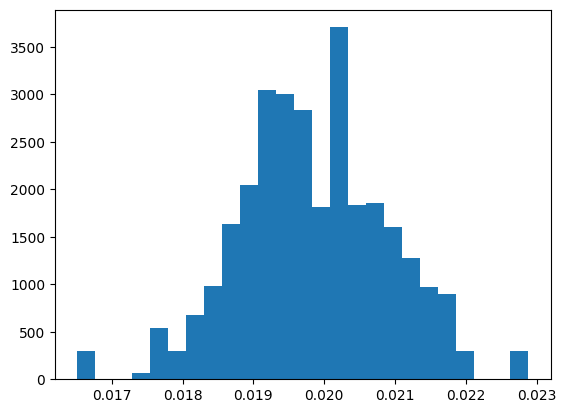

In [37]:
plt.hist(e_post_plus[:, :, 0].ravel(), bins=25)

In [10]:
true_g = jnp.array([0.02, 0.0])

In [15]:
raw_pipeline = partial(
    pipeline_shear_inference_simple,
    sigma_e=_shape_noise,
    sigma_e_int=_sigma_e_int,
    n_samples=3000,
    initial_step_size=1e-3,
    max_num_doublings=2
)
pipe = jit(raw_pipeline)


In [16]:
# jit
_ = pipe(k2, e_post_plus[:2, :, :], true_g)

In [17]:
g_samples_plus = pipe(k2, e_post_plus, init_g=jnp.array([0.,0.]))

In [18]:
g_samples_minus = pipe(k2, e_post_minus, init_g=jnp.array([0.,0.]))

In [19]:
g_samples_plus.shape, g_samples_minus.shape

((3000, 2), (3000, 2))

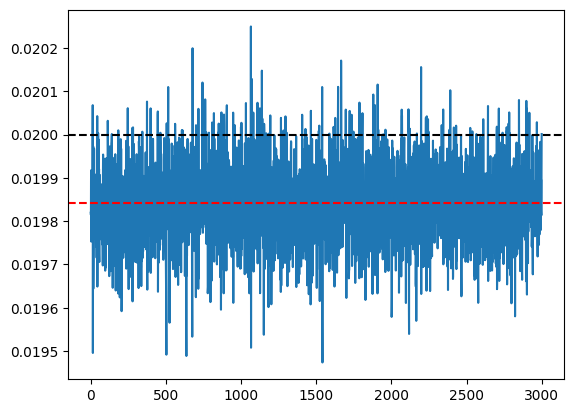

In [20]:
g1p = g_samples_plus[:, 0]

plt.plot(g1p)
plt.axhline(g1p.mean(), color='r', linestyle='--')
plt.axhline(0.02, color='k', linestyle='--')

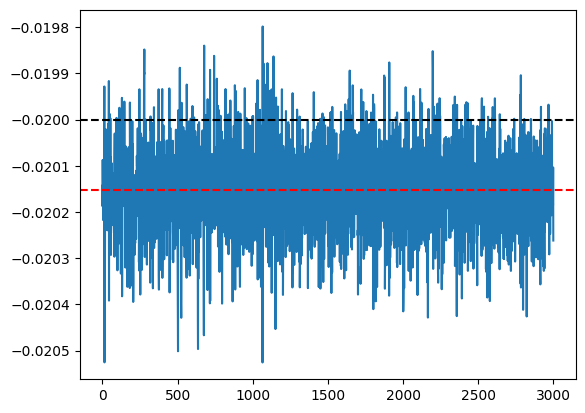

In [21]:
g1m = g_samples_minus[:, 0]

plt.plot(g1m)
plt.axhline(g1m.mean(), color='r', linestyle='--')
plt.axhline(-0.02, color='k', linestyle='--')

/pscratch/sd/i/imendoza/miniconda3/envs/bpd_gpu3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


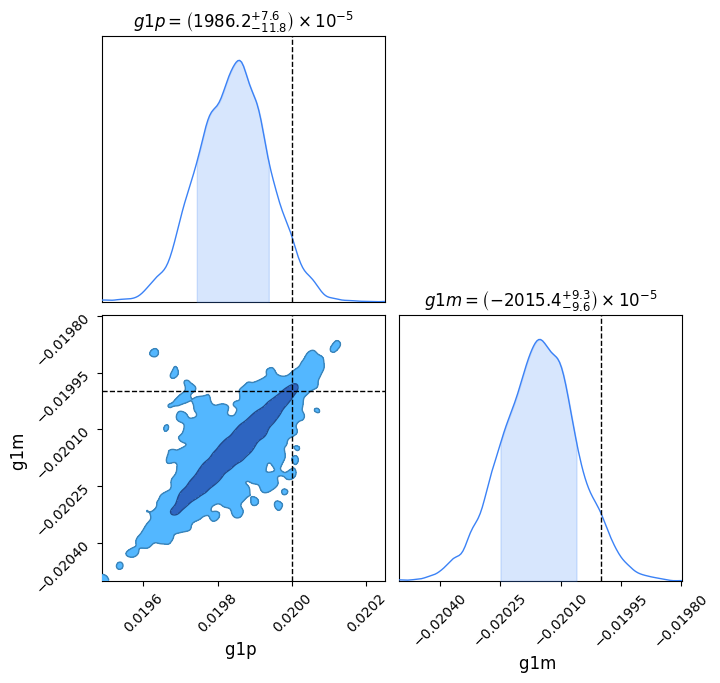

In [22]:
from bpd.diagnostics import get_contour_plot
_ = get_contour_plot([{'g1p':g1p, 'g1m':g1m}], ['post'], {'g1p':0.02, 'g1m':-0.02})

In [23]:
abs(g1p.mean().item() - 0.02), abs(g1m.mean().item() + 0.02)

(0.00015778703423418444, 0.00015288670153070644)

In [24]:
g1p.mean(), g1m.mean()

(Array(0.01984221, dtype=float64), Array(-0.02015289, dtype=float64))

## another setup

In [20]:
seed = 52
rng_key = random.key(seed)

k1, k2 = random.split(rng_key)

In [21]:
_shape_noise = 0.01
_sigma_e_int = 0.05

In [26]:
samples_plus = get_galaxy_samples(k1, g1=0.02, n_gals=100, 
                                  mean_logflux=4.0, sigma_logflux=0.4, 
                                  shape_noise=_shape_noise, sigma_e_int=_sigma_e_int)

In [27]:
samples_minus = get_galaxy_samples(k1, g1=-0.02, n_gals=100, 
                                   mean_logflux=4.0, sigma_logflux=0.4, 
                                  shape_noise=_shape_noise, sigma_e_int=_sigma_e_int)

In [28]:
e_post_plus = jnp.stack([samples_plus['e1'], samples_plus['e2']], axis=-1)
e_post_minus = jnp.stack([samples_minus['e1'], samples_minus['e2']], axis=-1)

e_post_plus.shape, e_post_minus.shape

((100, 300, 2), (100, 300, 2))

(array([3.000e+00, 2.000e+00, 3.000e+00, 9.000e+00, 9.000e+00, 1.500e+01,
        3.000e+01, 4.500e+01, 1.440e+02, 7.210e+02, 2.080e+03, 7.435e+03,
        8.337e+03, 7.428e+03, 2.871e+03, 4.720e+02, 2.040e+02, 1.230e+02,
        3.700e+01, 1.300e+01, 4.000e+00, 7.000e+00, 3.000e+00, 3.000e+00,
        2.000e+00]),
 array([-0.08231644, -0.0741976 , -0.06607876, -0.05795992, -0.04984108,
        -0.04172224, -0.0336034 , -0.02548456, -0.01736572, -0.00924688,
        -0.00112804,  0.0069908 ,  0.01510964,  0.02322848,  0.03134732,
         0.03946616,  0.047585  ,  0.05570384,  0.06382268,  0.07194152,
         0.08006036,  0.0881792 ,  0.09629804,  0.10441688,  0.11253572,
         0.12065456]),
 <BarContainer object of 25 artists>)

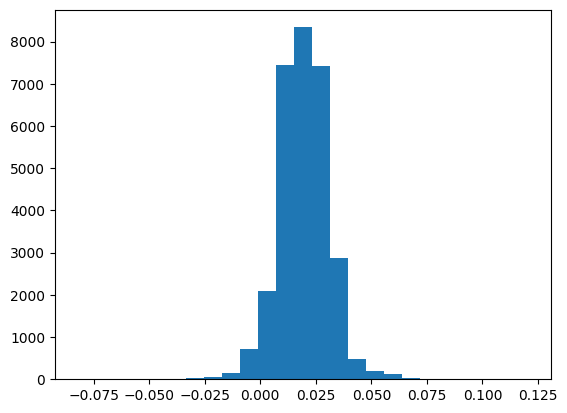

In [29]:
plt.hist(e_post_plus[:, :, 0].ravel(), bins=25)

In [18]:
true_g = jnp.array([0.02, 0.0])

In [29]:
raw_pipeline = partial(
    pipeline_shear_inference_simple,
    sigma_e=_shape_noise,
    sigma_e_int=_sigma_e_int,
    n_samples=3000,
    initial_step_size=1e-1,
    max_num_doublings=2
)
pipe = jit(raw_pipeline)


In [30]:
# jit
_ = pipe(k2, e_post_plus[:2, :, :], true_g)

In [31]:
g_samples_plus = pipe(k2, e_post_plus, init_g=jnp.array([0.,0.]))

In [22]:
g_samples_minus = pipe(k2, e_post_minus, init_g=jnp.array([0.,0.]))

In [23]:
g_samples_plus.shape, g_samples_minus.shape

((3000, 2), (3000, 2))

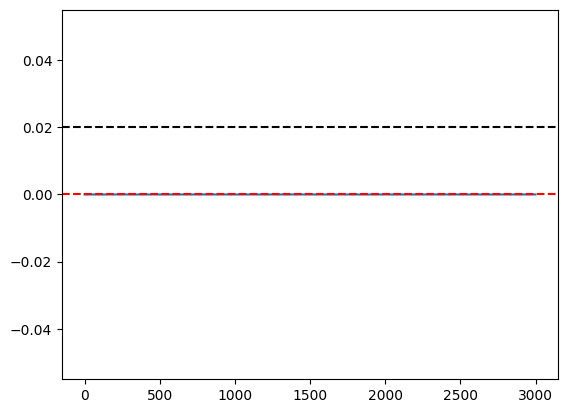

In [32]:
g1p = g_samples_plus[:, 0]

plt.plot(g1p)
plt.axhline(g1p.mean(), color='r', linestyle='--')
plt.axhline(0.02, color='k', linestyle='--')

In [25]:
g1p

Array([0., 0., 0., ..., 0., 0., 0.], dtype=float64)